# Pandas Join vs Merge Speed Test

Testing the speed of pandas join and merge  

**Conclusions**  
*Smaller Dataset (10K & 50K)*
* Join is certainly faster than merge in `left` join, with a `smaller` dataset on the left
* Join could be faster than merge in all methods, ranging from `-25% - ≥ 45%` (range various in different run)
* Join in other methods could be slower than merge with relative small dataset

*Larger Dataset (100K & 500K)*
* join speed advantage to merge is shrinking
* but more certain it is faster in all methods, except for inner join vs inner merge
    * inner join is almost the same as inner merge, but could be faster sometimes

**Author**  
Pengxiang Xu  
Data Scientist 

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

## Create DataFrames

* df1 is a smaller dataframe of the two
* df2 is larger

In [2]:
n1 = 10_000
df1 = pd.DataFrame({
    'a1': [a for a in range(n1)],
    'b': [str(b) for b in range(n1)]
})
df1 = df1.sample(frac=1) # Shuffle dataframe
df1.head(2)

,a1,b
9984,9984,9984
551,551,551


In [3]:
n2 = 50_000
df2 = pd.DataFrame({
    'a2': [a for a in range(n2)],
    'b': [str(b) for b in range(n2)]
})
df2 = df2.sample(frac=1)
df2.head(2)

,a2,b
48381,48381,48381
29387,29387,29387


## Set a timing decroator 

In [4]:
def time_function(func):
    """
    Time the function execution time

    Args:
        func: function

    Returns:
        wrap_func: function return results
    """
    import time

    def wrap_func(*args, **kwargs):
        if 'stats' in kwargs and kwargs['stats']:
            n_iter = 50
            if 'n_iter' in kwargs:
                n_iter = kwargs['n_iter']
                _ = kwargs.pop('n_iter')
            _ = kwargs.pop('stats')
            
            delta_ts = list()
            
            for i in range(n_iter):
                start = time.time()
                rst = func(*args, **kwargs)
                end = time.time()
                delta_ts.append(end - start)
            delta_t_avg = np.mean(delta_ts)
            delta_t_std = np.std(delta_ts)

            print(f"{kwargs['how']} {func.__name__} executed in " + 
                  f"{delta_t_avg:.5f}s on averge, with {delta_t_std:.5f}s in 1 Std.")
            return delta_t_avg, delta_t_std
        else:
            start = time.time()
            rst = func(*args, **kwargs)
            end = time.time()

            delta_t = end - start
            print(f"{kwargs['how']} {func.__name__} executed in {delta_t:.5f}s")
            return delta_t
    return wrap_func

In [5]:
merge_join_how = ['inner', 'left', 'right', 'outer']
time_dict = dict()

## Merge
Merge on column `b`

In [6]:
@time_function
def merge(df1, df2, **kwargs):
    """
    Merge
    
    Args:
        df1: dataframe 1
        df2: dataframe 2
    """
    _ = df1.merge(df2, **kwargs)

In [7]:
time_dict[('merge', 'avg')] = list()
time_dict[('merge', 'std')] = list()

for how in merge_join_how:
    t_avg, t_std = merge(df1, df2, on='b', how=how, stats=True)
    
    time_dict[('merge', 'avg')] .append(t_avg)
    time_dict[('merge', 'std')].append(t_std)

inner merge executed in 0.01640s on averge, with 0.00494s in 1 Std.
left merge executed in 0.01402s on averge, with 0.00282s in 1 Std.
right merge executed in 0.01923s on averge, with 0.00205s in 1 Std.
outer merge executed in 0.01794s on averge, with 0.00172s in 1 Std.


## Join
Set index on `b`, then join

In [8]:
%%time
df1_ = df1.set_index('b')
df2_ = df2.set_index('b')

CPU times: user 3.27 ms, sys: 538 µs, total: 3.81 ms
Wall time: 3.33 ms


In [9]:
@time_function
def join(df1, df2, **kwargs):
    """
    Join
    
    Args:
        df1: dataframe 1
        df2: dataframe 2
    """
    _ = df1.join(df2, **kwargs)

In [10]:
time_dict[('join', 'avg')] = list()
time_dict[('join', 'std')] = list()

for how in merge_join_how:
    t_avg, t_std = join(df1_, df2_, on='b', how=how, stats=True)
    
    time_dict[('join', 'avg')].append(t_avg)
    time_dict[('join', 'std')].append(t_std)

inner join executed in 0.01491s on averge, with 0.00298s in 1 Std.
left join executed in 0.01114s on averge, with 0.00112s in 1 Std.
right join executed in 0.01933s on averge, with 0.00276s in 1 Std.
outer join executed in 0.01832s on averge, with 0.00141s in 1 Std.


## Compare

In [11]:
df = pd.DataFrame(time_dict, index=merge_join_how)
df

merge                join          
            avg       std       avg       std
inner  0.016404  0.004936  0.014911  0.002982
left   0.014017  0.002821  0.011139  0.001120
right  0.019226  0.002050  0.019331  0.002762
outer  0.017943  0.001722  0.018324  0.001410

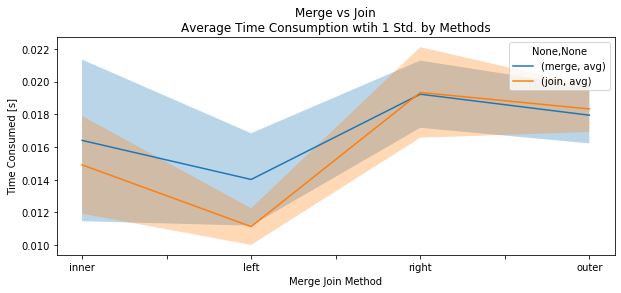

In [12]:
merge_std_p1 = df[('merge', 'avg')].values + df[('merge', 'std')].values
merge_std_n1 = df[('merge', 'avg')].values - df[('merge', 'std')].values
join_std_p1 = df[('join', 'avg')].values + df[('join', 'std')].values
join_std_n1 = df[('join', 'avg')].values - df[('join', 'std')].values

ax = df[[('merge', 'avg'), ('join', 'avg')]].plot.line(figsize=(10, 4))
_ = ax.fill_between(df.index, merge_std_p1, merge_std_n1, alpha=0.3)
_ = ax.fill_between(df.index, join_std_p1, join_std_n1, alpha=0.3)
_ = ax.set_xlabel('Merge Join Method')
_ = ax.set_ylabel('Time Consumed [s]')
_ = ax.set_title('Merge vs Join\nAverage Time Consumption wtih 1 Std. by Methods')

## Join is Faster, by How Much?
* Join is faster some cases
* Join is certainly faster in left join vs left merge `≥25% faster` with the smaller dataset on the left-side
* Join in other methods could be slower than merge with relative small dataset

In [13]:
df['join_n_pct_faster'] = (df[('merge', 'avg')] - df[('join', 'avg')]) / df[('merge', 'avg')] * 100.0

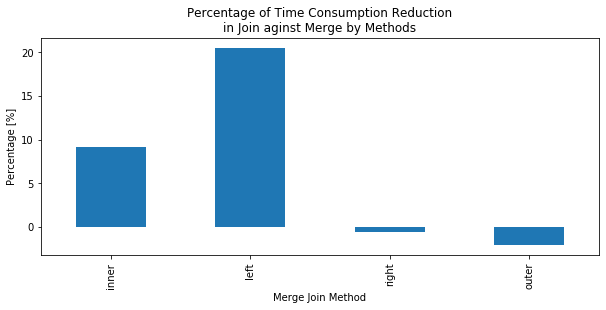

In [14]:
ax = df[['join_n_pct_faster']].plot.bar(figsize=(10, 4), legend=False)
_ = ax.set_xlabel('Merge Join Method')
_ = ax.set_ylabel('Percentage [%]')
_ = ax.set_title('Percentage of Time Consumption Reduction\nin Join aginst Merge by Methods')

In [15]:
df[['join_n_pct_faster']]

,join_n_pct_faster
,
inner,9.102571
left,20.531277
right,-0.548552
outer,-2.121310


## What Happen if Data Gets Larger

In [16]:
n3 = 100_000
df3 = pd.DataFrame({
    'a3': [a for a in range(n3)],
    'b': [str(b) for b in range(n3)]
})
df3 = df3.sample(frac=1)
df3.head(2)

,a3,b
62323,62323,62323
10496,10496,10496


In [17]:
n4 = 500_000
df4 = pd.DataFrame({
    'a4': [a for a in range(n4)],
    'b': [str(b) for b in range(n4)]
})
df4 = df4.sample(frac=1)
df4.head(2)

,a4,b
460108,460108,460108
215668,215668,215668


## Run Larger Dataset Test

In [18]:
larger_time_dict = dict()

In [19]:
larger_time_dict[('merge', 'avg')] = list()
larger_time_dict[('merge', 'std')] = list()

for how in merge_join_how:
    t_avg, t_std = merge(df3, df4, on='b', how=how, stats=True, n_iter=10)
    
    larger_time_dict[('merge', 'avg')] .append(t_avg)
    larger_time_dict[('merge', 'std')].append(t_std)

inner merge executed in 0.34833s on averge, with 0.01186s in 1 Std.
left merge executed in 0.35387s on averge, with 0.00981s in 1 Std.
right merge executed in 0.47702s on averge, with 0.01590s in 1 Std.
outer merge executed in 0.46127s on averge, with 0.00822s in 1 Std.


In [20]:
larger_time_dict[('join', 'avg')] = list()
larger_time_dict[('join', 'std')] = list()

df3_ = df3.set_index('b')
df4_ = df4.set_index('b')

for how in merge_join_how:
    t_avg, t_std = join(df3_, df4_, on='b', how=how, stats=True, n_iter=10)
    
    larger_time_dict[('join', 'avg')].append(t_avg)
    larger_time_dict[('join', 'std')].append(t_std)

inner join executed in 0.34387s on averge, with 0.00410s in 1 Std.
left join executed in 0.28353s on averge, with 0.01092s in 1 Std.
right join executed in 0.45089s on averge, with 0.01509s in 1 Std.
outer join executed in 0.43446s on averge, with 0.01451s in 1 Std.


In [21]:
df_large = pd.DataFrame(larger_time_dict, index=merge_join_how)
df_large

merge                join          
            avg       std       avg       std
inner  0.348332  0.011857  0.343867  0.004099
left   0.353874  0.009809  0.283535  0.010918
right  0.477022  0.015904  0.450894  0.015091
outer  0.461266  0.008216  0.434463  0.014513

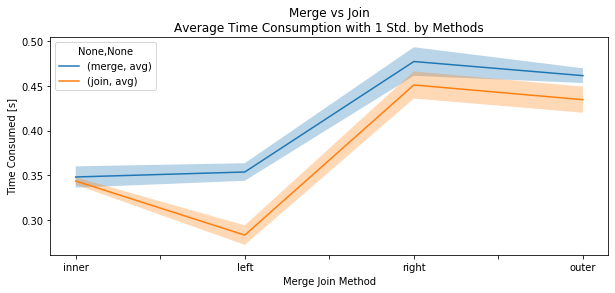

In [22]:
merge_large_std_p1 = df_large[('merge', 'avg')].values + df_large[('merge', 'std')].values
merge_large_std_n1 = df_large[('merge', 'avg')].values - df_large[('merge', 'std')].values
join_large_std_p1 = df_large[('join', 'avg')].values + df_large[('join', 'std')].values
join_large_std_n1 = df_large[('join', 'avg')].values - df_large[('join', 'std')].values

ax = df_large[[('merge', 'avg'), ('join', 'avg')]].plot.line(figsize=(10, 4))
_ = ax.fill_between(df_large.index, merge_large_std_p1, merge_large_std_n1, alpha=0.3)
_ = ax.fill_between(df_large.index, join_large_std_p1, join_large_std_n1, alpha=0.3)
_ = ax.set_xlabel('Merge Join Method')
_ = ax.set_ylabel('Time Consumed [s]')
_ = ax.set_title('Merge vs Join\nAverage Time Consumption with 1 Std. by Methods')

## Left Join Advantage is Shrinking with Larger Dataset

In [23]:
df_large['join_n_pct_faster'] = (df_large[('merge', 'avg')] - df_large[('join', 'avg')]) / df_large[('merge', 'avg')] * 100.0

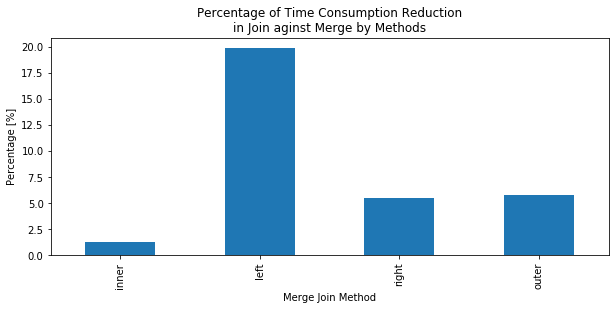

In [24]:
ax = df_large[['join_n_pct_faster']].plot.bar(figsize=(10, 4), legend=False)
_ = ax.set_xlabel('Merge Join Method')
_ = ax.set_ylabel('Percentage [%]')
_ = ax.set_title('Percentage of Time Consumption Reduction\nin Join aginst Merge by Methods')

In [25]:
df_large[['join_n_pct_faster']]

,join_n_pct_faster
,
inner,1.281806
left,19.876919
right,5.477477
outer,5.810768
